# BOS model presentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
try:
    if path:
        raise Exception('changed')
except:
    path = True
    sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from tqdm.notebook import tqdm

from src.model_tools import group_sum
from src.bos_model_polynomials import compute_polynomials
from src.bos_model_estimator import compute_log_likelihood, univariate_em, estimate_mu_pi_bos, probability_x_given_mu_pi_using_u
from src.data_generator import bos_model_sample

# BOS model generation

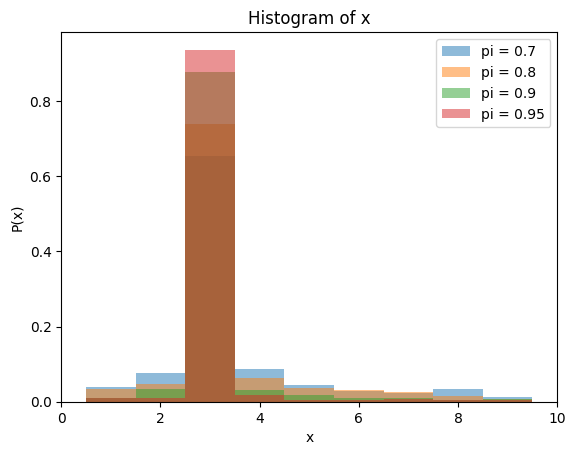

In [3]:
for pi in [0.7, 0.8, 0.9, 0.95]:
    xs = bos_model_sample(m=10, mu=3, pi=pi, n_sample=1_000)
    plt.hist(xs, label=f"pi = {pi}", alpha=0.5, bins=[i + 0.5 for i in range(10)], density=True)
plt.xlabel("x")
plt.ylabel("P(x)")
plt.title("Histogram of x")
plt.xlim(0, 10)
plt.legend()

# BOS model estimation

In [5]:
u = compute_polynomials(5)

The goal of estimation is to find $\pi$ and $\mu$ that maximize the likelihood function $L_X(\pi, \mu)$.

$L_X(\pi, \mu) = \sum_{i=1}^{n} \log\left[ \sum_{d = 0}^{m - 1} \left(\pi\right)^d u(x^i, \mu, m - d - 1) \right]$

To do this we can optimize the log-likelihood function $l_X(\pi, \mu)$ for each possible value of $\mu$ and then choose the one with the best likelihood.

We can look what does the log-likelihood function look like for a given $\mu$ :

In [6]:
def plot_log_likelihoods(
    m: int,
    mu: int,
    pi: float,
    u: np.ndarray,
    nb_pi: int = 1_000,
    data: np.ndarray = None,
    nb_sample: int = None,
    seed: int = 0,
) -> None:
    """
    Plot the log-likelihoods P(X | pi, mu) over pi in [0, 1] for each mu in [1, m]

    Parameters
    ----------
    m : int
        Number of categories
    mu : int
        True category
    pi : float
        Probability of error
    u : np.ndarray
        u coefficients computed with compute_u
    nb_pi : int
        Number of points to plot
    data : np.ndarray
        Data observed if None the data are generated from the god model
    nb_sample : int
        Number of samples to generate from the god model if data is None
    seed : int
        Seed for the random number generator if data is None
    """
    assert 1 <= mu <= m, f"mu={mu} not in [1, m]"
    assert 0 <= pi <= 1, f"pi={pi} not in [0, 1]"
    assert u.shape == (m, m, m), f"u.shape={u.shape} != (m, m, m)"
    assert (data is None) ^ (
        nb_sample is None
    ), f"data={data} and nb_sample={nb_sample} are not consistent"
    if data is None:
        data = bos_model_sample(m=m, mu=mu, pi=pi, n_sample=nb_sample, seed=seed)

    # group data
    weights = group_sum(m, data)
    data = np.arange(1, m + 1)

    u = compute_polynomials(m)
    
    pi_range = np.arange(1, nb_pi) / nb_pi
    log_likelihoods = np.zeros((m, nb_pi - 1))
    for i in tqdm(range(1, m + 1)):
        for j, _pi in enumerate(pi_range):
            log_likelihoods[i - 1, j] = compute_log_likelihood(
                m=m, pi=_pi, mu=i, u=u, weights=weights, probability_x_given_mu_pi=probability_x_given_mu_pi_using_u
            )

    plt.figure(figsize=(10, 5))
    for i in range(1, m + 1):
        plt.plot(
            pi_range,
            log_likelihoods[i - 1],
            label=f"mu={i}",
            linewidth=2 if i == mu else 1,
        )

    plt.xlabel("pi")
    plt.ylabel("log likelihood")
    plt.axvline(pi, color="r", linestyle="--", label="pi")
    plt.title(f"True parameters mu={mu}, pi={pi}")
    plt.legend()
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

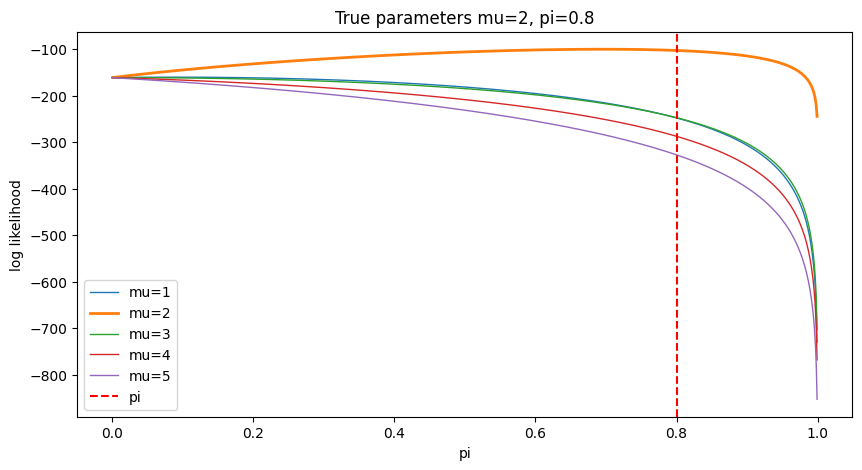

In [7]:
plot_log_likelihoods(m=5, mu=2, pi=0.8, u=u, nb_sample=100, seed=0)

Those functions are concaves in $\pi$ hence we can use trichothonic search to find its maximum (this is fast enough for our purposes).

## With trichotomy

In [8]:
%%time
for i in range(1, 6):
    for pi in [0.6, 0.7, 0.8, 0.9, 1.0]:
        xs = bos_model_sample(m=5, mu=i, pi=pi, n_sample=1_000, seed=0)
        mu_hat, pi_hat, _, _ = estimate_mu_pi_bos(m=5, data=xs, u=u)
        print(f"mu={i}, mu_hat={mu_hat}, pi_error {abs(pi - pi_hat):.2e}, {'O' if mu_hat == i else 'X'}")

mu=1, mu_hat=1, pi_error 4.06e-03, O
mu=1, mu_hat=1, pi_error 2.80e-02, O
mu=1, mu_hat=1, pi_error 2.95e-02, O
mu=1, mu_hat=1, pi_error 1.04e-02, O
mu=1, mu_hat=1, pi_error 3.91e-06, O
mu=2, mu_hat=2, pi_error 3.19e-02, O
mu=2, mu_hat=2, pi_error 5.96e-03, O
mu=2, mu_hat=2, pi_error 3.08e-03, O
mu=2, mu_hat=2, pi_error 9.21e-03, O
mu=2, mu_hat=2, pi_error 3.91e-06, O
mu=3, mu_hat=3, pi_error 2.99e-02, O
mu=3, mu_hat=3, pi_error 1.08e-02, O
mu=3, mu_hat=3, pi_error 1.00e-02, O
mu=3, mu_hat=3, pi_error 8.37e-03, O
mu=3, mu_hat=3, pi_error 3.91e-06, O
mu=4, mu_hat=4, pi_error 7.86e-03, O
mu=4, mu_hat=4, pi_error 1.11e-02, O
mu=4, mu_hat=4, pi_error 7.86e-03, O
mu=4, mu_hat=4, pi_error 2.97e-03, O
mu=4, mu_hat=4, pi_error 3.91e-06, O
mu=5, mu_hat=5, pi_error 3.66e-02, O
mu=5, mu_hat=5, pi_error 3.13e-02, O
mu=5, mu_hat=5, pi_error 1.57e-02, O
mu=5, mu_hat=5, pi_error 1.64e-03, O
mu=5, mu_hat=5, pi_error 3.91e-06, O
CPU times: user 2.42 s, sys: 11.5 ms, total: 2.43 s
Wall time: 2.41 s


## With EM

In [13]:
%%time
for i in range(1, 6):
    for pi in [0.6, 0.7, 0.8, 0.9, 1.0]:
        xs = bos_model_sample(m=5, mu=i, pi=pi, n_sample=1_000, seed=0)
        mu_hat, pi_hat, _, _ = univariate_em(m=5, data=xs, u=u)
        print(f"mu={i}, mu_hat={mu_hat}, pi_error {abs(pi - pi_hat):.2e}, {'O' if mu_hat == i else 'X'}")

mu=1, mu_hat=1, pi_error 2.32e-04, O
mu=1, mu_hat=1, pi_error 3.17e-02, O
mu=1, mu_hat=1, pi_error 3.32e-02, O
mu=1, mu_hat=1, pi_error 1.29e-02, O
mu=1, mu_hat=1, pi_error 0.00e+00, O
mu=2, mu_hat=2, pi_error 2.80e-02, O
mu=2, mu_hat=2, pi_error 9.72e-03, O
mu=2, mu_hat=2, pi_error 6.38e-03, O
mu=2, mu_hat=2, pi_error 1.18e-02, O
mu=2, mu_hat=2, pi_error 0.00e+00, O
mu=3, mu_hat=3, pi_error 2.58e-02, O
mu=3, mu_hat=3, pi_error 7.63e-03, O
mu=3, mu_hat=3, pi_error 6.78e-03, O
mu=3, mu_hat=3, pi_error 6.16e-03, O
mu=3, mu_hat=3, pi_error 0.00e+00, O
mu=4, mu_hat=4, pi_error 3.56e-03, O
mu=4, mu_hat=4, pi_error 1.48e-02, O
mu=4, mu_hat=4, pi_error 1.10e-02, O
mu=4, mu_hat=4, pi_error 6.11e-04, O
mu=4, mu_hat=4, pi_error 0.00e+00, O
mu=5, mu_hat=5, pi_error 3.28e-02, O
mu=5, mu_hat=5, pi_error 2.79e-02, O
mu=5, mu_hat=5, pi_error 1.27e-02, O
mu=5, mu_hat=5, pi_error 7.35e-04, O
mu=5, mu_hat=5, pi_error 0.00e+00, O
CPU times: user 44.8 s, sys: 124 ms, total: 44.9 s
Wall time: 45 s


# Compute u benchmark

In [9]:
def benchmark_f(f, m_max: int, sample: int=10):
    times = []
    for m in tqdm(range(m_max, 0, -1)):
        t = perf_counter()
        for _ in range(sample):
            _ = f(m)
        times.append((perf_counter() - t) / sample)
    times.reverse()
    return times

In [5]:
m_max = 70
sample = 10
alpha = 1.797e-08
k = 4
predicted_time = alpha * m_max ** k
total_predicted_time = alpha * m_max ** (k + 1) / (k + 1)
print(f'predicted time: {sample * predicted_time:.2f} seconds, {sample * predicted_time / 60:.2f} minutes')
print(f'total predicted time: {sample * total_predicted_time:.2f} seconds, {sample * total_predicted_time / 60:.2f} minutes')
bench_v1 = np.array(benchmark_f(compute_polynomials, m_max, sample=sample))
print(f"{bench_v1[-1]: .2f} seconds")

predicted time: 4.31 seconds, 0.07 minutes
total predicted time: 60.40 seconds, 1.01 minutes


  0%|          | 0/70 [00:00<?, ?it/s]

 1.29 seconds


t(m) = 1.306e-06m^3 ?
t(m) = 4.889e-07m^3.25 ?
t(m) = 1.845e-07m^3.5 ?
t(m) = 7.030e-08m^3.75 ?
t(m) = 2.712e-08m^4 ?
t(m) = 1.063e-08m^4.25 ?
t(m) = 4.253e-09m^4.5 ?


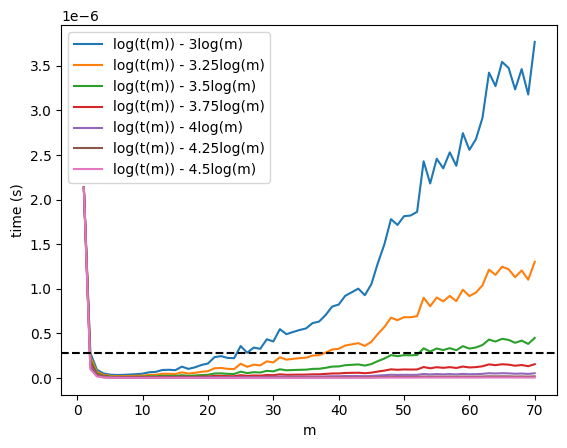

In [6]:
bench = bench_v1
m_max = bench.shape[0]

for k in (3, 3.25, 3.5, 3.75, 4, 4.25, 4.5):
    c = np.mean(bench[5:] / np.arange(5, m_max) ** k)
    print(f"t(m) = {c:.3e}m^{k} ?")
    plt.plot(range(1, m_max + 1), bench / np.arange(1, m_max + 1) ** k, label=f'log(t(m)) - {k}log(m)')
plt.axhline(bench[1] / 8, color='black', linestyle='--')
plt.ylabel('time (s)')
plt.xlabel('m')
plt.legend()

# Estimation benchmark

In [12]:
n = 1_000
perfs = []
for m in tqdm(range(2, 40)):
    xs = bos_model_sample(m=m, mu=1, pi=0.8, n_sample=n, seed=0)
    t = perf_counter()
    mu_hat, pi_hat, _, _ = estimate_mu_pi_bos(m=m, data=xs)
    perfs.append(perf_counter() - t)

  0%|          | 0/38 [00:00<?, ?it/s]

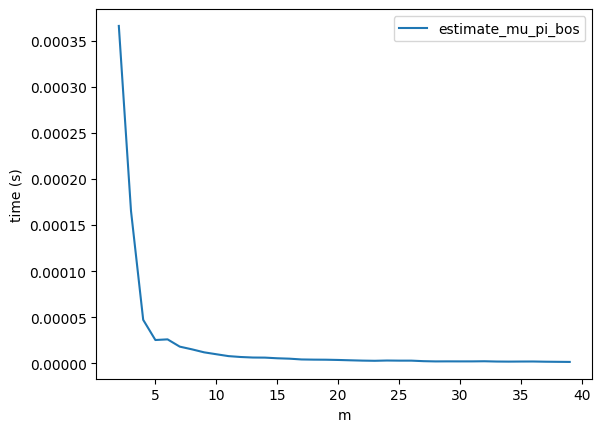

In [16]:
# plot the performance
plt.plot(range(2, 40), [p / (i + 2) ** 4 for i, p in enumerate(perfs)] , label='estimate_mu_pi_bos')
plt.xlabel('m')
plt.ylabel('time (s)')
plt.legend()

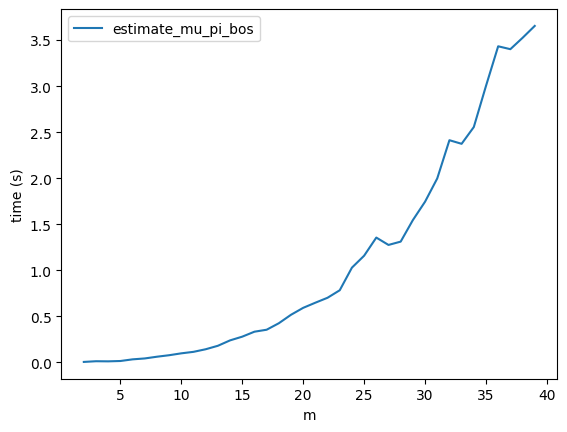

In [17]:
# plot the performance
plt.plot(range(2, 40), perfs , label='estimate_mu_pi_bos')
plt.xlabel('m')
plt.ylabel('time (s)')
plt.legend()